### This is an adaptation of the Coursera code (originally built with tensorflow), on this one i used Keras to make the model part simpler, maybe it can help people that are new to deep learning or anyone else that want to use Keras on this competition.

#### Notes: 
* [Link for a tensorflow version](https://www.kaggle.com/dimitreoliveira/tensorflow-dnn-coursera-ml-course-code)
* [Link for a more complete version on Github](https://github.com/dimitreOliveira/NewYorkCityTaxiFare)
* I'm not using "passenger count" because it something that is not supposed to really matter in this case.
* I've created two features derived from "hour" (night and late night), according to some research i did it's added an additional value if it's a business day (mon ~ fri), and it's night, also there's another added value if it's dawn.
* I'm binning latitudes and longitudes to make it easier to work with.
* Even tough deep learning is robust enough to deal with noisy data, i'm removing outliers (it may save some memory).
* Currently i'm using both Euclidean and Manhattan distances, it may be a bit redundant, but they have a different meaning and i'm still not sure of witch one is better(if you have some insights about this please let me know)

### Dependencies

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


## Data clean
### Here i'm removing some outliers, and noisy data.
* Lats and lons that do not belong to New York.
* Negative fare.
* Fare greater than 250 (this seems to be noisy data).
* Rides that begin and end in the same location.

In [2]:
def clean(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

## Feature engineering
*  Now i'll do some feature engineering and process the data, i'm basically creating 3 kinds of features.
    *  **Time features**
        * Year, Month, Day, Hour, Weekday
        * Night (between 16h and 20h, from monday to friday)
        * Late night (between 20h and and 6h)
    * **Coordinate features**
        * Latitude difference (difference from pickup and dropout latitudes)
        * Longitude difference (difference from pickup and dropout longitudes)
    * **Distances features**
        * Euclidean (Euclidean distance from pickup and dropout)
        * Manhattan (Manhattan distance from pickup and dropout)
        * Manhattan distances from pickup location and downtown, JFK, EWR and LGR airports (see if the ride started at one of these locations).
        * Manhattan distances from dropout location and downtown, JFK, EWR and LGR airports (see if the ride ended at one of these locations).

In [3]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    
    
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['pickup_datetime'] =  df['pickup_datetime'].apply(lambda x: str(x))
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
    return df


def add_coordinate_features(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)

    return df


def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df

### Auxiliar functions

In [4]:
def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')
    
    
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### Parameters

In [5]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SUBMISSION_NAME = 'submission_keras.csv'

# Model parameters
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_SIZE = 6000000

### Load data

In [6]:
# Load values in a more compact form
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

# Only a fraction of the whole data
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE, dtype=datatypes, usecols=[1,2,3,4,5,6])
test = pd.read_csv(TEST_PATH)

#### Clean and process data

In [7]:
train = clean(train)

train = add_time_features(train)
test = add_time_features(test)

add_coordinate_features(train)
add_coordinate_features(test)

train = add_distances_features(train)
test = add_distances_features(test)

train.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hour,weekday,...,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,-73.844315,40.721317,-73.841614,40.712276,2009,6,15,17,0,...,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,-74.016045,40.711304,-73.979271,40.782005,2010,1,5,16,1,...,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2011,8,18,0,3,...,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,-73.987129,40.733143,-73.991570,40.758091,2012,4,21,4,5,...,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,-73.968094,40.768009,-73.956657,40.783764,2010,3,9,7,1,...,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


In [8]:
# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns + ['key', 'passenger_count'], axis=1)

# peek data
train_clean.head(5)

,fare_amount,year,month,day,hour,weekday,night,late_night,latdiff,londiff,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,4.5,2009,6,15,17,0,1,0,0.009041,-0.002701,0.009436,0.011742,0.169225,0.166665,0.139243,0.127501,0.362003,0.355663,0.074368,0.086110
1,16.9,2010,1,5,16,1,1,0,-0.070702,-0.036774,0.079693,0.107475,0.012519,0.094957,0.300959,0.334887,0.180259,0.287734,0.204741,0.121276
2,5.7,2011,8,18,0,3,0,1,0.010708,0.008507,0.013676,0.019215,0.070756,0.051542,0.317614,0.315413,0.263534,0.244319,0.121466,0.140681
3,7.7,2012,4,21,4,5,0,1,-0.024948,0.004440,0.025340,0.029388,0.038236,0.058744,0.293883,0.323272,0.231014,0.251521,0.153986,0.133479
4,5.3,2010,3,9,7,1,0,0,-0.015755,-0.011436,0.019468,0.027191,0.092138,0.119329,0.309714,0.314032,0.284915,0.312106,0.100085,0.100421


#### Split data in train and validation (90% ~ 10%)

In [9]:
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)

# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [10]:
# Scale data
# Note: im doing this here with sklearn scaler but, on the Coursera code the scaling is done with Dataflow and Tensorflow
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)

### Model

In [11]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

### Model parameters

In [12]:
print('Dataset size: %s' % DATASET_SIZE)
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_df.columns)

Dataset size: 6000000
Epochs: 50
Learning rate: 0.001
Batch size: 256
Input dimension: 19
Features used: Index(['year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night',
       'latdiff', 'londiff', 'euclidean', 'manhattan',
       'downtown_pickup_distance', 'downtown_dropoff_distance',
       'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance',
       'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance'],
      dtype='object')


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5120      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
__________

### Train model

In [14]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Train on 5225686 samples, validate on 580632 samples
Epoch 1/50
5225686/5225686 [==============================] - 272s 52us/step - loss: 19.5504 - mean_absolute_error: 2.2813 - val_loss: 32.7090 - val_mean_absolute_error: 4.2261
Epoch 2/50
5225686/5225686 [==============================] - 135s 26us/step - loss: 15.4867 - mean_absolute_error: 1.9898 - val_loss: 17.7139 - val_mean_absolute_error: 2.5407
Epoch 3/50
5225686/5225686 [==============================] - 135s 26us/step - loss: 15.3133 - mean_absolute_error: 1.9768 - val_loss: 19.9614 - val_mean_absolute_error: 2.7708
Epoch 4/50
5225686/5225686 [==============================] - 135s 26us/step - loss: 15.1734 - mean_absolute_error: 1.9664 - val_loss: 19.2163 - val_mean_absolute_error: 2.4442
Epoch 5/50
5225686/5225686 [==============================] - 135s 26us/step - loss: 15.1240 - mean_absolute_error: 1.9619 - val_loss: 48.4163 - val_mean_absolute_error: 5.7449
Epoch 6/50
5225686/5225686 [==============================] - 

5225686/5225686 [==============================] - 134s 26us/step - loss: 14.9026 - mean_absolute_error: 1.9705 - val_loss: 15483.3974 - val_mean_absolute_error: 3.5598
Epoch 47/50
5225686/5225686 [==============================] - 136s 26us/step - loss: 14.9183 - mean_absolute_error: 1.9717 - val_loss: 2351.7901 - val_mean_absolute_error: 2.4908
Epoch 48/50
5225686/5225686 [==============================] - 136s 26us/step - loss: 14.8899 - mean_absolute_error: 1.9697 - val_loss: 2211.8700 - val_mean_absolute_error: 2.4458
Epoch 49/50
5225686/5225686 [==============================] - 138s 26us/step - loss: 14.8609 - mean_absolute_error: 1.9680 - val_loss: 1144.0855 - val_mean_absolute_error: 2.2129
Epoch 50/50
5225686/5225686 [==============================] - 134s 26us/step - loss: 14.8876 - mean_absolute_error: 1.9715 - val_loss: 5416.6674 - val_mean_absolute_error: 2.4512


### Plot metrics

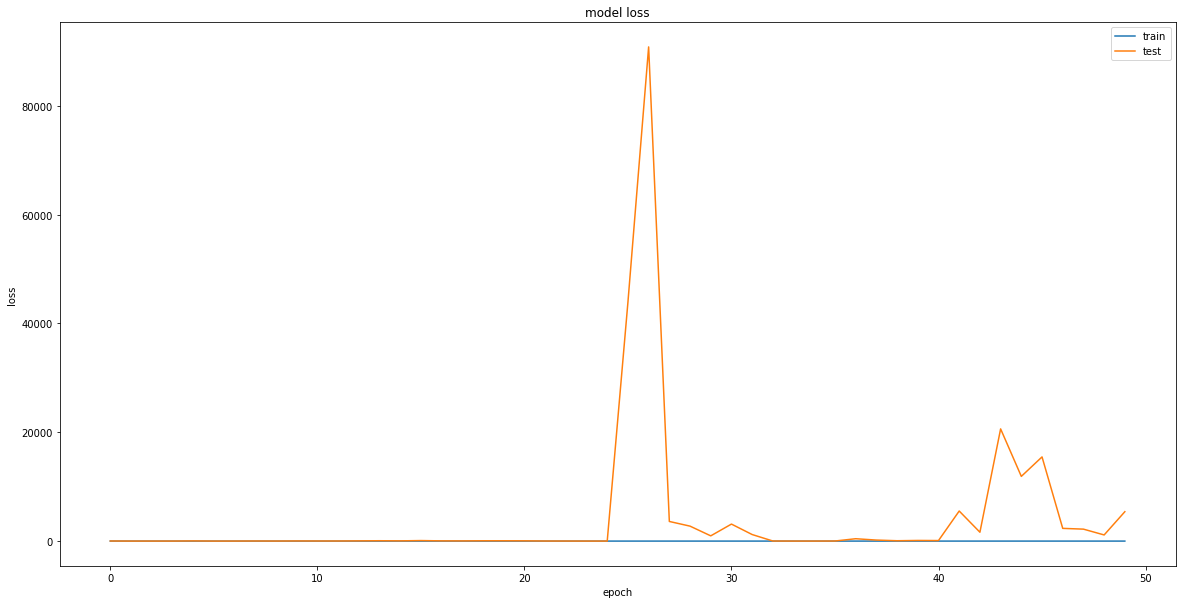

In [15]:
plot_loss_accuracy(history)

In [16]:
# Make prediction
prediction = model.predict(test_scaled, batch_size=128, verbose=1)

9914/9914 [==============================] - 0s 20us/step


In [17]:
# output prediction
output_submission(test, prediction, 'key', 'fare_amount', SUBMISSION_NAME)

Output complete
